<table style="font-size: 1em; padding: 0; margin: 0;">

<tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #182AEB; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #ffffff;">Deep Learning </span> for Satellite Image Classification</span> (Manning Publications)<br/>by <em>Daniel Buscombe</em></strong><br/><br/>
        <strong>> Chapter 2: Deliverable Solution </strong><br/>
    </p>           

Load the necessary libraries

In [1]:
from PIL import Image, ImageDraw
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json, os, glob
import rasterio

Repurpose the ```make_plot``` function from Part 2 tutorial, using only the parts used to extract the coordinates from each lake polygon

In [2]:
def get_data(data):
    X = []; Y = [] #pre-allocate lists to fill in a for loop
    for k in data['regions']: #cycle through each polygon
        # get the x and y points from the dictionary
        X.append(data['regions'][k]['shape_attributes']['all_points_x'])
        Y.append(data['regions'][k]['shape_attributes']['all_points_y'])
    return Y,X #image coordinates are flipped relative to json coordinates

Create a new directory to store your label images

In [3]:
os.mkdir('s2cloudless_label_imagery')
os.mkdir('s2cloudless_label_imagery'+os.sep+'data')

This function gets the X,Y polygon coordinates, creates a mask, and saves the mask to file. The function is composed mostly of commands shown in the Part 2 tutorial

In [4]:
def write_mask(data, images, all_images, i):
    X, Y = get_data(data[images[i]])
    
    # get the dimensions of the image
    nx, ny, nz = np.shape(all_images[i])
    mask = np.zeros((ny,nx))
    
    for x,y in zip(X,Y):
        # the ImageDraw.Draw().polygon function we will use to create the mask
        # requires the x's and y's are interweaved, which is what the following
        # one-liner does    
        polygon = np.vstack((x,y)).reshape((-1,),order='F').tolist()
        
        # create a mask image of the right size and infill according to the polygon
        if nx>ny:
            x,y = y,x 
            img = Image.new('L', (ny, nx), 0)
        elif ny>nx:
            x,y = y,x 
            img = Image.new('L', (ny, nx), 0)            
        else:
            img = Image.new('L', (nx, ny), 0)
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        # turn into a numpy array
        m = np.flipud(np.rot90(np.array(img)))
        try:
            mask = mask + m
        except:
            mask = mask + m.T
    matplotlib.image.imsave('s2cloudless_label_imagery'+os.sep+'data'+os.sep+images[i]+"_mask.jpg", mask.astype('uint8'))    

Load the VGG-JSON labels file and extract the list of sample imagess

In [5]:
data = json.load(open('..'+os.sep+'2_Data'+os.sep+'s2cloudless_labels'+os.sep+'all_labels.json'))
images = sorted(data.keys())

Load all the image samples into an array, like in the Part tutorial

In [6]:
all_images = []
for image in images:
    with rasterio.open('..'+os.sep+'2_Data'+os.sep+'s2cloudless_imagery'+os.sep+'data'+os.sep+image) as dataset:
        all_images.append(dataset.read().T)

/Users/fasteno/.virtualenvs/satellite/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Call ```write mask``` to write the image mask for each image sample, according to the information in ```data```, the json label structure

In [7]:
for i in range(len(images)):
    write_mask(data, images, all_images, i)

Use ```glob``` to load a list of these image filenames, then read then into an array ```all_labels``` one-by-one

In [8]:
labels = sorted(glob.glob('s2cloudless_label_imagery'+os.sep+'data'+os.sep+'*.jpg'))

In [9]:
all_labels = []
for image in labels:
    with rasterio.open(image) as dataset:
        all_labels.append(dataset.read().T[:,:,0]) #np.flipud(np.rot90(

Overlay a mask on an image to double-check that worked

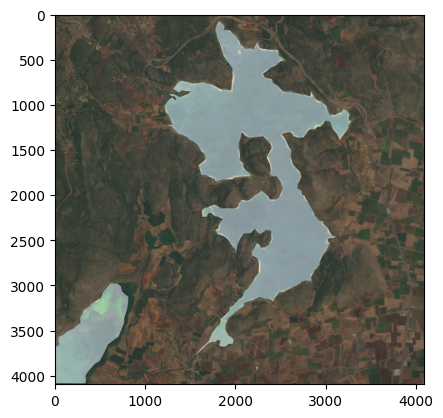

In [10]:
plt.imshow(all_images[10])
plt.imshow(all_labels[10], cmap='gray', alpha=0.5)